In [1]:
import warnings

warnings.filterwarnings('ignore')

import os
import random
import optuna
import numpy as np
import pandas as pd
import scipy.stats as st
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler, OneHotEncoder

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything()

In [3]:
df = pd.read_csv('./impute_set/imp3.csv')


def preprocessing(df, num, cat, numeric, category, train=True):
    df_num, df_cat = df[num], df[cat]
    if train:
        df_num = pd.DataFrame(numeric.fit_transform(df_num), columns=df_num.columns)
        df_cat = pd.DataFrame(category.fit_transform(df_cat), columns=df_cat.columns)
    else:
        df_num = pd.DataFrame(numeric.transform(df_num), columns=df_num.columns)
        df_cat = pd.DataFrame(category.transform(df_cat), columns=df_cat.columns)
    res = pd.concat([df_num, df_cat], axis=1)
    return res


def test_with_5fold(df, numeric='minmax', category='label', shuffle=True):
    f1s = []
    pppreds = []
    tttrues = []

    X = df.drop('BS3_1', axis=1)
    y = df[['BS3_1']]
    numeric_col = [
        'FEV1', 'FEV1FVC', 'age', 'BS6_3', 'BS6_2_1', 'BD1',
        '건강문해력', 'Total_slp_wk', 'EQ_5D', 'BE3_31', 'BE5_1', '질환유병기간'
    ]
    cat_col = []
    for col in X.columns:
        if col not in numeric_col:
            cat_col.append(col)

    df_num, df_cat = X[numeric_col], X[cat_col]
    if numeric == 'minmax':
        n_pre = MinMaxScaler()
    else:
        n_pre = StandardScaler()
    df_num = pd.DataFrame(n_pre.fit_transform(df_num), columns=df_num.columns)

    if category == 'label':
        c_pre = OrdinalEncoder()
        df_cat = pd.DataFrame(c_pre.fit_transform(df_cat), columns=df_cat.columns)
    else:
        c_pre = OneHotEncoder(sparse_output=False)
        df_cat = pd.DataFrame(c_pre.fit_transform(df_cat))
        # df_cat = df_cat.astype(float)

    X = pd.concat([df_num, df_cat], axis=1)

    if shuffle:
        # skf = StratifiedKFold(n_splits=5, shuffle=shuffle, random_state=42)
        skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    else:
        # skf = StratifiedKFold(n_splits=5, shuffle=shuffle)
        skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    # X.reset_index().drop('index', axis=1, inplace=True)
    # y.reset_index().drop('index', axis=1, inplace=True)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        # print(fold+1)
        train_X, train_y = X.iloc[train_idx], y.iloc[train_idx]
        test_X, test_y = X.iloc[test_idx], y.iloc[test_idx]
        pos = train_y.value_counts()[0] / train_y.value_counts()[1]
        print(pos)

        # model = XGBClassifier(random_state=42, n_estimators=20, max_depth=4, scale_pos_weight=pos)
        params = {'n_estimators': 124, 'max_depth': 7, 'learning_rate': 0.003339207651158001, 'gamma': 1.6458936755157638, 'alpha': 4.85704056557763, 'lambda': 2.5184353943919406, 'min_child_weight': 0.3826429176896404, 'max_delta_step': 38, 'subsample': 0.1563403720918737, 'sampling_method': 'uniform', 'tree_method': 'approx', 'grow_policy': 'lossguide', 'max_bin': 339}
        model = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, scale_pos_weight=pos, **params)
        model.fit(train_X, train_y, verbose=False, eval_set=[(train_X, train_y),(test_X, test_y)])
        preds = model.predict(test_X)
        f1_ = f1_score(test_y, preds, average='macro')
        f1s.append(f1_)
        pppreds += list(preds)
        tttrues += list(test_y.values)
    return f1s, pppreds ,tttrues


def get_cv_results(f1s:list):
    f1s = np.array(f1s)
    mean_f1 = np.mean(f1s)
    std_f1 = np.std(f1s)
    ci95 = st.t.interval(.95, df=len(f1s)-1, loc=mean_f1, scale=std_f1/np.sqrt(len(f1s)))
    return mean_f1, std_f1, ci95

In [4]:
f1s, ppreds, ttrues = test_with_5fold(df, numeric='standard')
mean_f1, std_f1, ci95 = get_cv_results(f1s)
# print(f1s)
print(f'CV Results: Mean {mean_f1:.2f} | Std {std_f1:.2f} | CI95% {ci95[0]:.2f}~{ci95[1]:.2f}')

5.829268292682927
5.829268292682927
5.829268292682927
5.829268292682927
6.0
5.829268292682927
5.829268292682927
5.829268292682927
5.829268292682927
6.0
5.829268292682927
5.829268292682927
5.829268292682927
5.829268292682927
6.0
CV Results: Mean 0.74 | Std 0.09 | CI95% 0.69~0.79


In [5]:
flattened = [x[0] for x in ttrues]

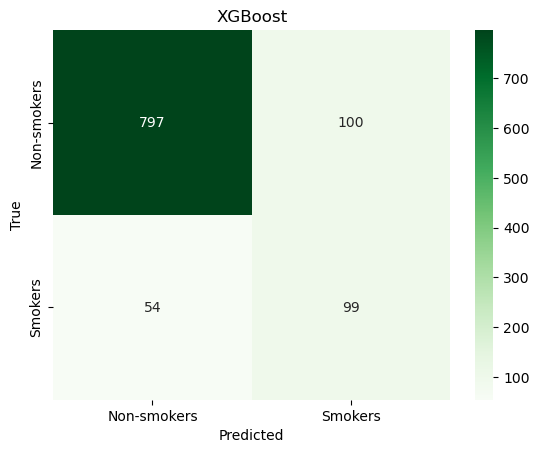

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.title('XGBoost')
sns.heatmap(
    confusion_matrix(flattened, ppreds), annot=True, fmt='.0f', 
    # xticklabels=['Smokers', 'Non-smokers'],
    # yticklabels=['Smokers', 'Non-smokers'],
    xticklabels=['Non-smokers', 'Smokers'],
    yticklabels=['Non-smokers', 'Smokers'],
    cmap='Greens'
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()